# Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import collections
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian
from scipy import integrate
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('df_t90.csv')
# Use read_csv function to read .csv file.

df.rename(columns={'Unnamed: 0': 'Original Index'}, inplace=True)
# Rename the column label of the 0th column in place.
df

Original Index  Condition  99.250815  103.762030  108.271065  112.775798  \
0                50         10     6996.0      7895.0      8063.0      7680.0   
1                51         10     6873.0      7913.0      8032.0      7884.0   
2                52         10     6950.0      7792.0      7852.0      7734.0   
3                53         10     6803.0      7710.0      8078.0      7790.0   
4                54         10     6927.0      7890.0      7936.0      7860.0   
..              ...        ...        ...         ...         ...         ...   
130             825         18     6768.0      7591.0      7950.0      7637.0   
131             826         18     6688.0      7589.0      7634.0      7470.0   
132             827         18     6711.0      7597.0      8002.0      7730.0   
133             828         18     6837.0      7669.0      7973.0      7829.0   
134             829         18     6740.0      7738.0      7790.0      7679.0   

     117.278356  121.778742  126.274835  130.766640  ...  2473.076347  \
0        7154.0      6601.0      6017.0      5641.0  ...        171.0   
1        7141.0      6651.0      6119.0      5695.0  ...        163.0   
2        7141.0      6570.0      6010.0      5544.0  ...        133.0   
3        7236.0      6633.0      5971.0      5525.0  ...        122.0   
4        7272.0      6611.0      6219.0      5426.0  ...        143.0   
..          ...         ...         ...         ...  ...          ...   
130      7076.0      6584.0      5995.0      5546.0  ...        196.0   
131      7051.0      6605.0      5916.0      5470.0  ...        236.0   
132      7148.0      6564.0      5983.0      5386.0  ...        200.0   
133      7037.0      6444.0      5958.0      5517.0  ...        190.0   
134      7126.0      6494.0      6143.0      5436.0  ...        218.0   

     2476.239604  2479.400013  2482.560815  2485.720391  2488.877123  \
0          164.0        194.0        167.0        166.0        217.0   
1          152.0        139.0        159.0        183.0        191.0   
2          158.0        147.0        180.0        193.0        187.0   
3          144.0        141.0        200.0        164.0        147.0   
4          129.0        184.0        173.0        198.0        172.0   
..           ...          ...          ...          ...          ...   
130        251.0        222.0        209.0        323.0        200.0   
131        208.0        285.0        220.0        259.0        224.0   
132        206.0        280.0        244.0        273.0        233.0   
133        265.0        236.0        244.0        258.0        251.0   
134        310.0        272.0        271.0        270.0        255.0   

     2492.034249  2495.188534  2498.338365  2501.490207  
0          159.0        165.0        152.0        150.0  
1          159.0        117.0         98.0        170.0  
2          119.0        174.0        167.0        189.0  
3          116.0        133.0        173.0        136.0  
4          149.0        139.0        168.0        137.0  
..           ...          ...          ...          ...  
130        182.0        209.0        193.0        205.0  
131        233.0        212.0        233.0        239.0  
132        210.0        205.0        230.0        231.0  
133        189.0        296.0        258.0        223.0  
134        224.0        226.0        222.0        297.0  

[135 rows x 639 columns]

# Test Plots and Baseline Correction

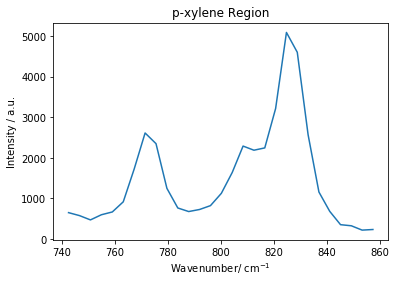

In [3]:
# Extract relevant p-xylene region and Vinyl region from the 1st spectra for
# baseline correction and plot tests.

pxyl_Region = df.iloc[0, 151:180] # Extract 1st spectra at the pxyl region and plot.
pxyl_Region.index = pxyl_Region.index.astype(float) # Change the index type to float.
pxyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
plt.show()

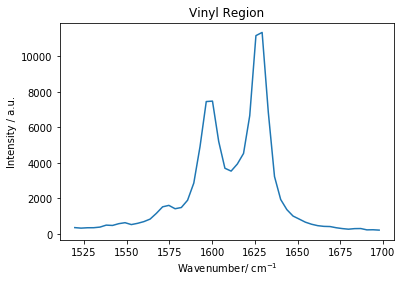

In [4]:
Vinyl_Region = df.iloc[0, 350:400] # Extract 1st spectra at the Vinyl region and plot.
Vinyl_Region.index = Vinyl_Region.index.astype(float) # Change the index type to float.
Vinyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
plt.show()

# Baseline Subtraction

## Custom

Choose two regions on the spectrum that you want to form the basis for the baseline. The spectrum is based on the truncated region of interest from the raw spectrum.

Choose from the curve above, <10 and >50 to form the x and y values to fit a polynomial line, serving as my baseline values. **Note that the x-axis is the placeholder index location of the truncated spectra, not the actual wavenumbers themselves**

p-xylene Region Baseline Subtraction

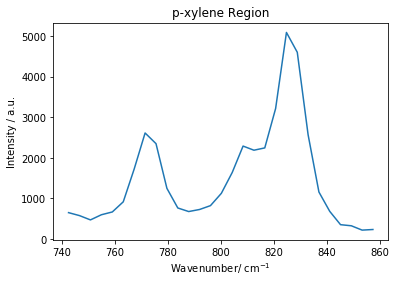

In [5]:
# p-xylene Region Baseline Subtraction
y = df.iloc[0, 151:180]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
y.plot()
plt.show()

# y is a Series. A pandas Series is a lablled/ indexed 1-D array. Therefore, a single argument of y,
# itself containing the intensity value (y-axis) at the corresponding wavenumber (x-axis) can be plotted. 

# Plot the 1st spectra (1st row) of df_t0.

In [6]:
xbl = [] # x-baseline.

for items in y.index[:5].values.tolist():
    xbl.append(items)

for items in y.index[25:].values.tolist():
    xbl.append(items)

# Recall that y is a Series with intensities labelled by their wavenumbers. y.index gives the Series labels, which are the 
# wavenumbers. y.index[:10] gives the 0th to 9th Series labels and is an index object. Convert the index object to a numpy
# array via y.index[:10].values, then put them into a list via y.index[:10].values.tolist().

# There are 2 for loops for the xbl (x baseline) list because you want the 1st 10 wavenumbers, but you also want the last
# wavenumbers from index 40 onwards. In the end, xbl is a single list containing all wavenumbers from index 0 to 9,
# and then from index 40 onwards. The same ideas apply for ybl, except for the fact that ybl contains intensities.

ybl = [] # y-baseline.

for items in y.values[:5].tolist():
    ybl.append(items)

for items in y.values[25:].tolist():
    ybl.append(items)
    
# y is a Pandas Series. Therefore, y.values immediately gives the values witihn that series, which are the intensities.

In [7]:
# Check that the range of xbl and ybl values makes sense.
xbl_and_ybl = list(zip(xbl, ybl))# Zip xbl and ybl together, then use list function to unpack the zipped object.
xbl_and_ybl

[(742.618633, 650.0),
 (746.747008, 577.0),
 (750.875475, 471.0),
 (755.002051, 598.0),
 (759.124757, 667.0),
 (845.161878, 353.0),
 (849.231664, 326.0),
 (853.299603, 219.0),
 (857.365695, 234.0)]

Running the baseline fit. **(x-values, y-values, polynomial degree)** are the arguments.

In [8]:
blpars = np.polyfit(xbl, ybl, 1)
# blpars contains the baseline parameters; the coefficients which will allow for the baseline polynomial to be defined.
# Fit a polynomial based on the x and y-values chosen for the spectra during the previous step. Thus, given a list of x values
# and its corresponding y-values, fit a polynomial through these points as best as you can. This polynomial will serve as the 
# baseline to be subtracted from the spectra's y-values. 
# numpy.polyfit(x, y, deg)
# np.polyfit: Least squares polynomial fit. Fit a polynomial p(x) = p[0] * x**deg + ... + p[deg] of degree deg to points (x, y).
# Returns a vector of coefficients p that minimises the squared error in the order deg, deg-1, … 0.
# Since degree = 1, we are fitting a straight line.

blfit = np.poly1d(blpars)
# A one-dimensional polynomial class. A convenience class, used to encapsulate “natural” operations on polynomials so that
# said operations may take on their customary form in code. blfit is a function that encompasses information on blpar's vector
# of coefficients derived from the np.polyfit step. It will take an input of x-values, then apply the coefficients to the
# x-values to obtain the best fit polynomial following the p(x) equation defined above.

Plot showing before and after subtraction.

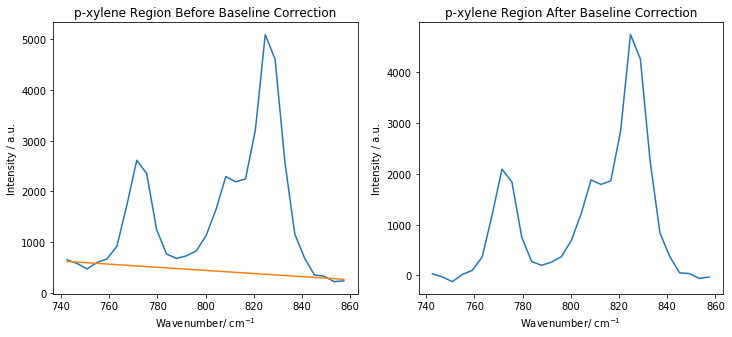

In [9]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1) # subplot(nrows, ncols, index)
plt.plot(y) # Plot the spectrum using the Series y.
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region Before Baseline Correction')
plt.plot(y.index, blfit(y.index))
# Plot the baseline polynomial to be subtracted (orange color). The x-axis will contain the wavenumbers. 
# Therefore y.index(Series labels) is being plotted at the x-axis. The y-axis will be blfit(y.index) because the output of 
# blfit(y.index) contains the y-values of the polynomial that is best fit to the input x-values.

plt.subplot(1,2,2)
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region After Baseline Correction')
plt.plot(y.index,(y - blfit(y.index)))
# Plot the baseline corrected spectrum. Subtraction can immediately be done because blfit(y.index) is a numpy array of y-values
# of the best fit polynomial. So the each value in Series y will minus each value in array blfit(y.index),
# to yield a final y value, which is the corrected spectra intensity. 

plt.show()

Vinyl Region Baseline Subtraction

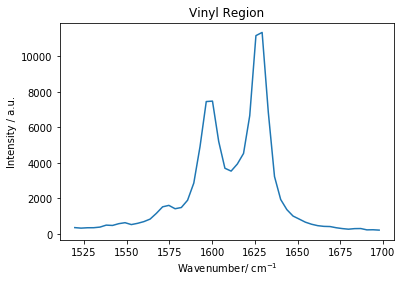

In [10]:
# Vinyl Region Baseline Subtraction
y = df.iloc[0, 350:400]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
y.plot()
plt.show()

In [11]:
xbl = []

for items in y.index[:10].values.tolist():
    xbl.append(items)

for items in y.index[40:].values.tolist():
    xbl.append(items)
    
ybl = []

for items in y.values[:10].tolist():
    ybl.append(items)

for items in y.values[40:].tolist():
    ybl.append(items)

In [12]:
xbl_and_ybl = list(zip(xbl, ybl))
xbl_and_ybl

[(1519.539364, 358.0),
 (1523.227008, 329.0),
 (1526.911261, 350.0),
 (1530.59394, 352.0),
 (1534.275047, 387.0),
 (1537.952769, 498.0),
 (1541.630734, 480.0),
 (1545.305318, 580.0),
 (1548.976525, 635.0),
 (1552.647977, 529.0),
 (1665.413023, 428.0),
 (1669.018935, 418.0),
 (1672.621543, 351.0),
 (1676.224416, 303.0),
 (1679.822206, 269.0),
 (1683.420263, 301.0),
 (1687.015025, 306.0),
 (1690.608275, 231.0),
 (1694.200013, 237.0),
 (1697.79024, 217.0)]

In [13]:
blpars = np.polyfit(xbl, ybl, 1)
blfit = np.poly1d(blpars)

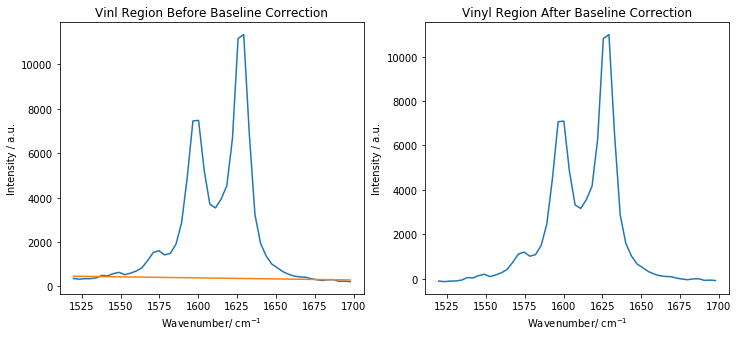

In [14]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.plot(y)
plt.plot(y.index, blfit(y.index))
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinl Region Before Baseline Correction')

plt.subplot(1,2,2)
plt.plot(y.index,(y - blfit(y.index))) 
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region After Baseline Correction')

plt.show()

# Fitting Functions

In [15]:
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian

def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']))
    
    return model - y

# Running Curve Fits

In [16]:
df_vinyl = df.iloc[:, 350:400].copy()
df_vinyl.columns = df_vinyl.columns.astype('float')
df_vinyl

1519.539364  1523.227008  1526.911261  1530.593940  1534.275047  \
0          358.0        329.0        350.0        352.0        387.0   
1          377.0        352.0        365.0        393.0        385.0   
2          355.0        376.0        358.0        405.0        410.0   
3          394.0        367.0        349.0        341.0        428.0   
4          332.0        340.0        356.0        382.0        371.0   
..           ...          ...          ...          ...          ...   
130        477.0        500.0        473.0        546.0        569.0   
131        525.0        601.0        491.0        600.0        556.0   
132        510.0        522.0        494.0        551.0        587.0   
133        595.0        543.0        541.0        546.0        555.0   
134        477.0        558.0        518.0        542.0        600.0   

     1537.952769  1541.630734  1545.305318  1548.976525  1552.647977  ...  \
0          498.0        480.0        580.0        635.0        529.0  ...   
1          491.0        469.0        531.0        615.0        546.0  ...   
2          537.0        521.0        538.0        579.0        573.0  ...   
3          466.0        512.0        528.0        656.0        606.0  ...   
4          472.0        503.0        516.0        573.0        522.0  ...   
..           ...          ...          ...          ...          ...  ...   
130        655.0        676.0        711.0        760.0        749.0  ...   
131        601.0        620.0        678.0        773.0        733.0  ...   
132        655.0        630.0        667.0        738.0        752.0  ...   
133        701.0        704.0        692.0        757.0        644.0  ...   
134        715.0        607.0        761.0        843.0        707.0  ...   

     1665.413023  1669.018935  1672.621543  1676.224416  1679.822206  \
0          428.0        418.0        351.0        303.0        269.0   
1          383.0        373.0        397.0        373.0        279.0   
2          386.0        409.0        328.0        332.0        269.0   
3          445.0        388.0        339.0        338.0        246.0   
4          500.0        338.0        425.0        316.0        274.0   
..           ...          ...          ...          ...          ...   
130        621.0        568.0        556.0        525.0        424.0   
131        689.0        528.0        545.0        508.0        451.0   
132        624.0        548.0        501.0        546.0        385.0   
133        633.0        516.0        556.0        523.0        489.0   
134        496.0        543.0        594.0        553.0        526.0   

     1683.420263  1687.015025  1690.608275  1694.200013  1697.790240  
0          301.0        306.0        231.0        237.0        217.0  
1          314.0        283.0        242.0        211.0        266.0  
2          272.0        259.0        254.0        174.0        238.0  
3          290.0        302.0        227.0        211.0        224.0  
4          284.0        273.0        249.0        206.0        283.0  
..           ...          ...          ...          ...          ...  
130        421.0        447.0        389.0        362.0        418.0  
131        471.0        465.0        512.0        361.0        404.0  
132        488.0        450.0        473.0        363.0        407.0  
133        470.0        470.0        420.0        395.0        460.0  
134        470.0        493.0        408.0        436.0        473.0  

[135 rows x 50 columns]

For 2 Lorentzians peak fits within the region of interest:

## Select initial guess parameters, namely amplitude, centre, width of the peaks.

In [17]:
ampL1 = 100000 # Peak Amplitude of 1st Peak
cenL1 = 1599 # Peak location of 1st Peak
widL1 = 10

ampL2 = 100000 # Peak Amplitude of 2nd Peak
cenL2 = 1627 # Peak location of 2nd Peak
widL2 = 6

## Fitting and Plotting (Vinyl Region)

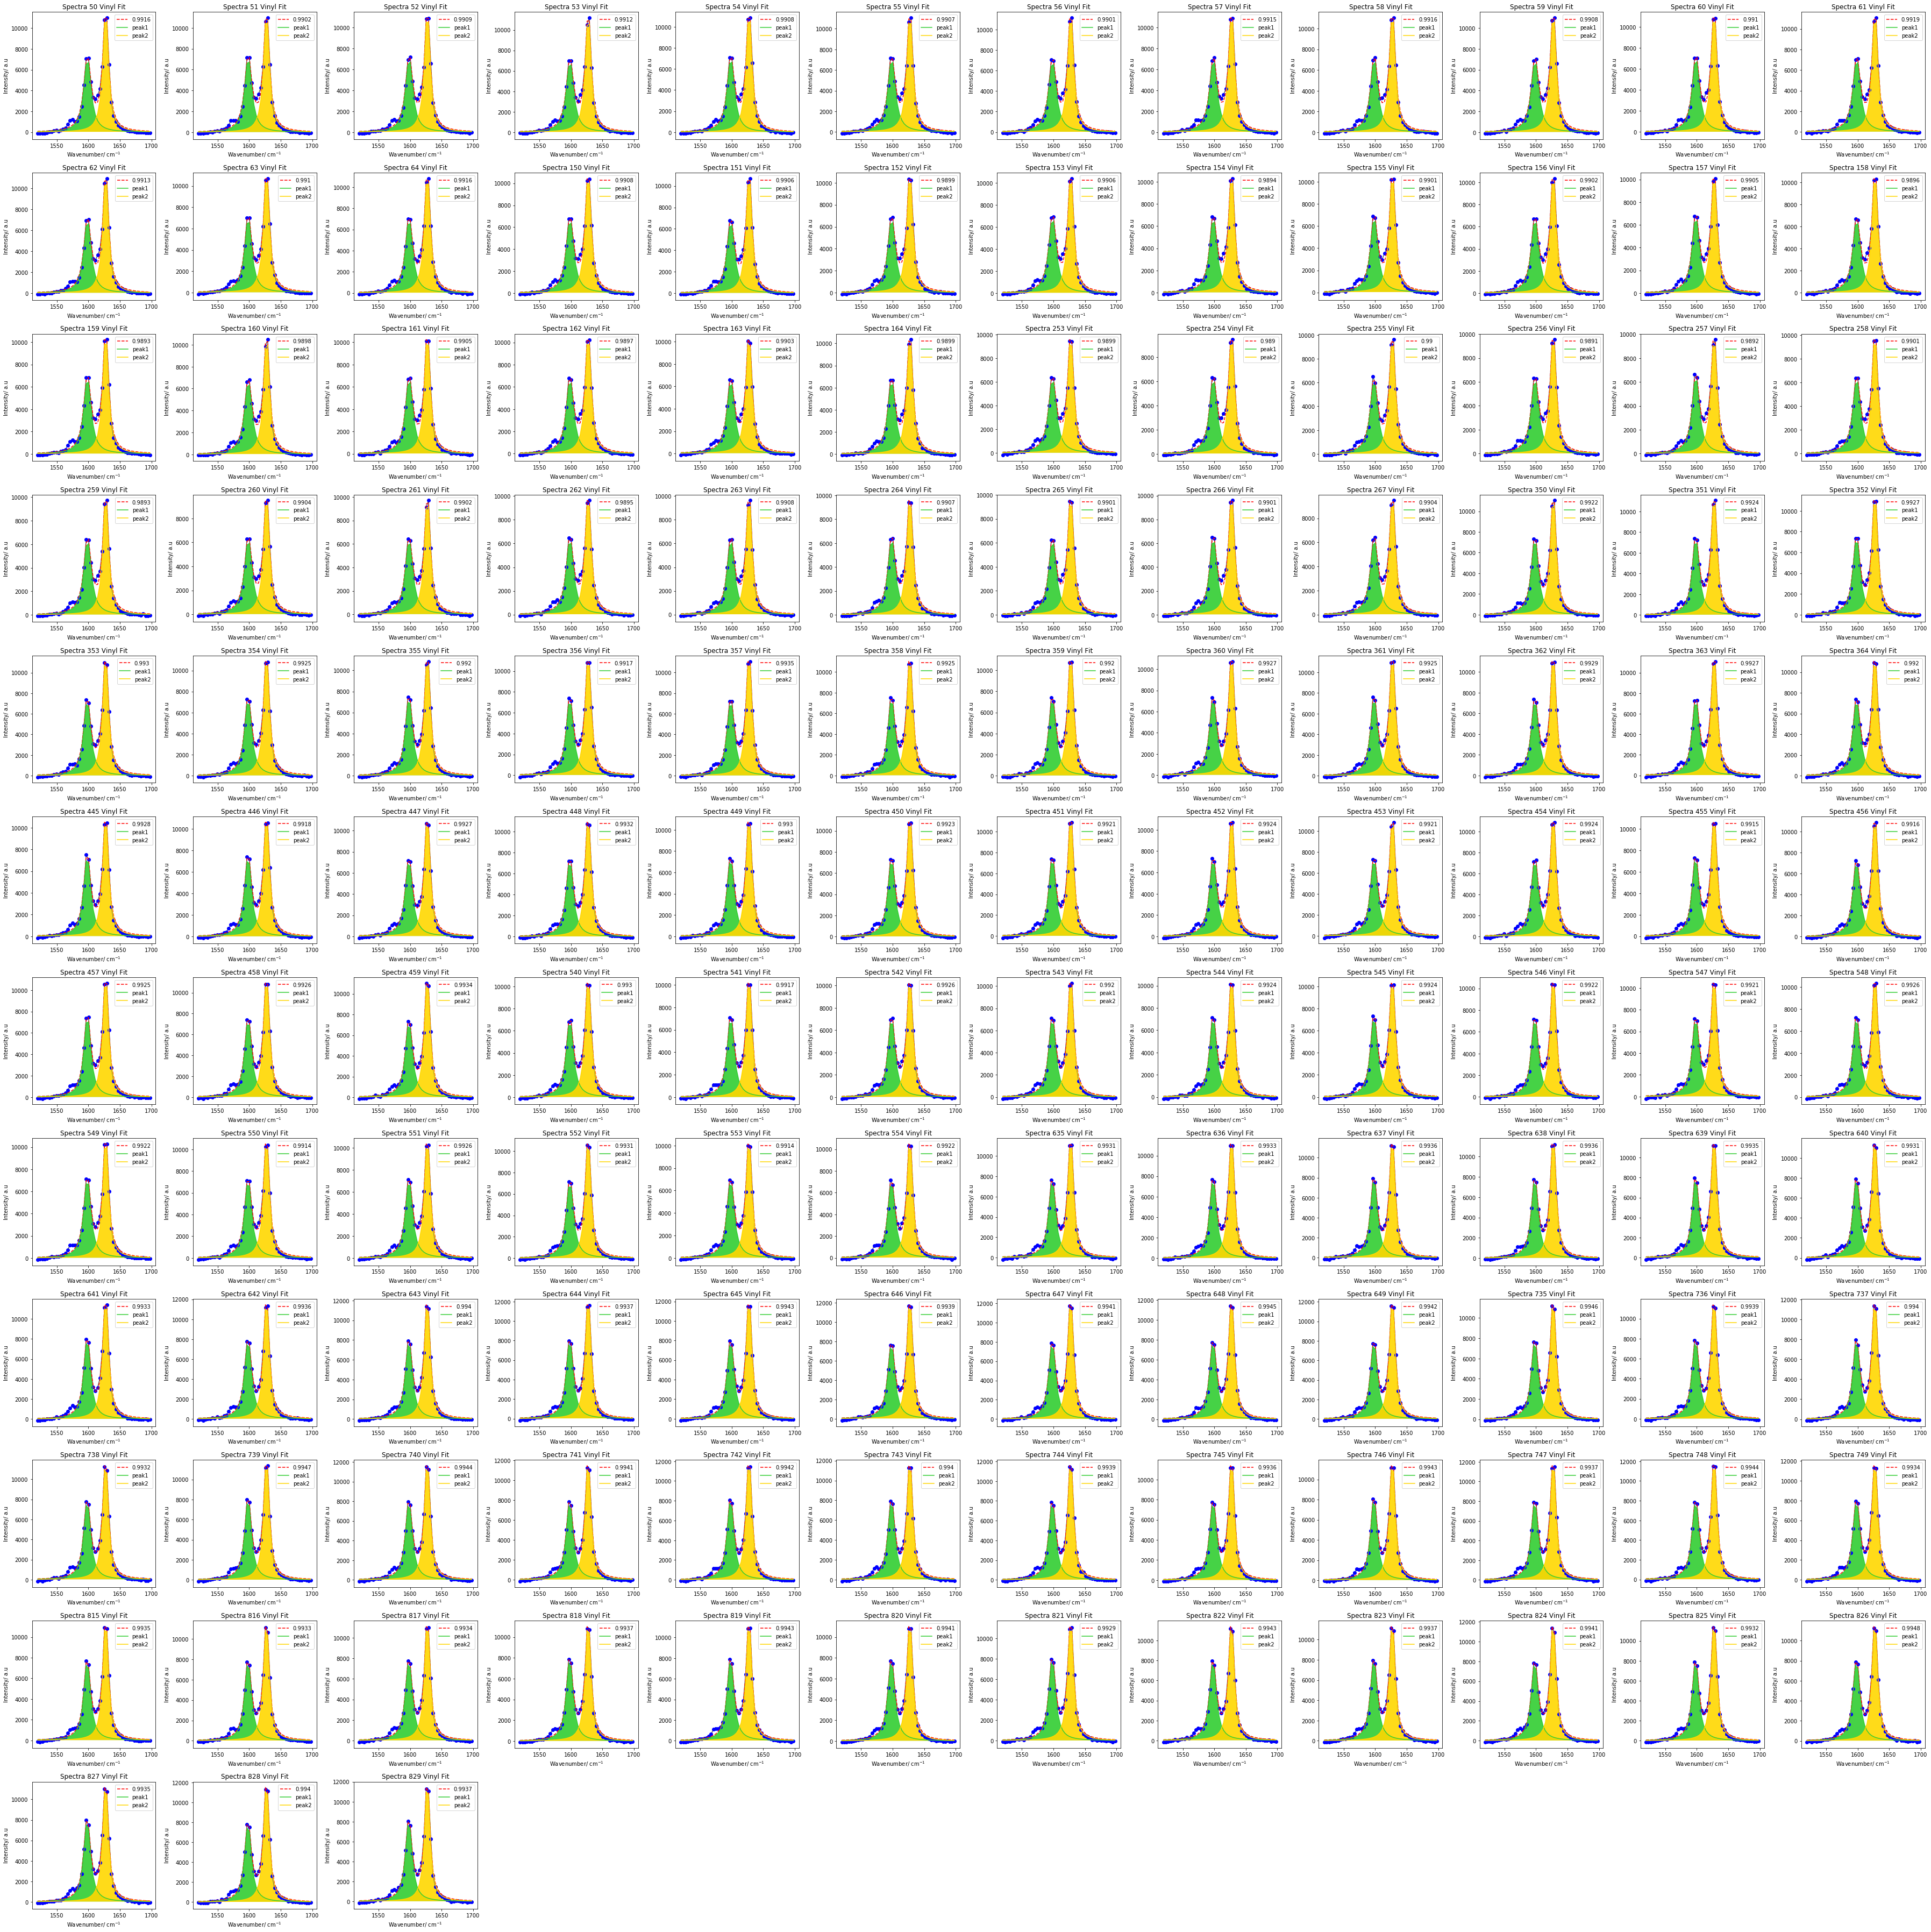

In [18]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])

pbar = tqdm(total = len(df_vinyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (50,50))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='cenL1', value = cenL1, max = 1605)
pfit.add(name='cenL2', value = cenL2, min = 1620, max = 1640)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)

for i,item in df_vinyl.iterrows():
    
    x = df_vinyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:10].values.tolist():
        xbl.append(items)

    for items in y.index[40:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:10].tolist():
        ybl.append(items)

    for items in y.values[40:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['Height_L1'] = 0.3183099*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.3183099*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    
    plt.subplot(np.ceil(np.sqrt(df_vinyl.shape[0])),np.ceil(np.sqrt(df_vinyl.shape[0])),(1+i))
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' Vinyl Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    
    pbar.update(1)
    
pbar.close()
    
plt.tight_layout()
plt.show()

In [19]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_Vinyl'}, inplace=True)
results.describe()

ampL1          ampL2        cenL1        cenL2       widL1  \
count     135.000000     135.000000   135.000000   135.000000  135.000000   
mean   153986.132052  191562.695742  1598.301584  1627.401872    6.772034   
std      6014.708031    9055.932835     0.198568     0.064707    0.295117   
min    140232.535539  169970.007627  1597.977486  1627.232273    6.208109   
25%    150542.875679  185868.054228  1598.133282  1627.358304    6.527450   
50%    154717.532001  193982.956871  1598.285845  1627.405197    6.735368   
75%    158267.628632  198174.377472  1598.485023  1627.449011    7.022143   
max    165657.118755  205979.659068  1598.660157  1627.568130    7.355871   

            widL2    R2_Vinyl     FWHM_L1     FWHM_L2    Height_L1  \
count  135.000000  135.000000  135.000000  135.000000   135.000000   
mean     5.301540    0.992197   13.544069   10.603080  7260.007938   
std      0.114817    0.001542    0.590234    0.229634   547.701155   
min      5.008264    0.989015   12.416218   10.016528  6147.916277   
25%      5.205245    0.990838   13.054900   10.410490  6924.978142   
50%      5.307614    0.992409   13.470737   10.615228  7243.963752   
75%      5.401373    0.993485   14.044287   10.802747  7793.139227   
max      5.556207    0.994808   14.711743   11.112414  8144.124619   

          Height_L2  
count    135.000000  
mean   11512.619933  
std      695.749739  
min     9967.419160  
25%    11020.855554  
50%    11661.439016  
75%    12018.130679  
max    12702.054481

For 2 Lorentzians peak fits within the region of interest:

In [20]:
Area_2 = pd.Series(Area_2)
labels = df.iloc[:, 0:2]
df_area = pd.concat([labels, Area_2, results['R2_Vinyl']], axis=1)
df_area.rename(columns={0: 'Vinyl Peak Area'}, inplace=True)
df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl
0                50         10    191170.418408  0.991583
1                51         10    191385.219115  0.990241
2                52         10    191217.485258  0.990860
3                53         10    189232.629993  0.991241
4                54         10    189532.481042  0.990826
..              ...        ...              ...       ...
130             825         18    190354.633285  0.993168
131             826         18    185233.016618  0.994808
132             827         18    186562.508959  0.993476
133             828         18    189691.137325  0.993985
134             829         18    188551.450955  0.993679

[135 rows x 4 columns]

# Fitting and Plotting (p-xylene Region)

In [21]:
df_pxyl = df.iloc[:, 151:180].copy()
df_pxyl.columns = df_pxyl.columns.astype('float')
df_pxyl

742.618633  746.747008  750.875475  755.002051  759.124757  763.245576  \
0         650.0       577.0       471.0       598.0       667.0       917.0   
1         651.0       595.0       491.0       541.0       697.0       887.0   
2         712.0       550.0       471.0       594.0       644.0       983.0   
3         629.0       558.0       501.0       567.0       627.0       839.0   
4         691.0       541.0       469.0       593.0       603.0       968.0   
..          ...         ...         ...         ...         ...         ...   
130       827.0       767.0       763.0       863.0       940.0      1199.0   
131       861.0       759.0       825.0       870.0       939.0      1114.0   
132       877.0       750.0       809.0       803.0       918.0      1193.0   
133       910.0       883.0       760.0       862.0       923.0      1171.0   
134       848.0       806.0       742.0       883.0       855.0      1270.0   

     767.364511  771.479584  775.592776  779.704089  ...  820.686591  \
0        1726.0      2615.0      2352.0      1249.0  ...      3218.0   
1        1707.0      2515.0      2323.0      1235.0  ...      3135.0   
2        1625.0      2612.0      2292.0      1266.0  ...      3195.0   
3        1679.0      2517.0      2281.0      1277.0  ...      3069.0   
4        1695.0      2601.0      2372.0      1306.0  ...      3055.0   
..          ...         ...         ...         ...  ...         ...   
130      2052.0      2921.0      2504.0      1505.0  ...      1979.0   
131      2037.0      2904.0      2518.0      1555.0  ...      1780.0   
132      2040.0      2793.0      2536.0      1505.0  ...      1790.0   
133      2006.0      2968.0      2541.0      1621.0  ...      1929.0   
134      1928.0      2897.0      2550.0      1511.0  ...      1810.0   

     824.769464  828.852443  832.933566  837.012832  841.088281  845.161878  \
0        5095.0      4606.0      2572.0      1159.0       682.0       353.0   
1        5105.0      4434.0      2435.0      1127.0       681.0       446.0   
2        4969.0      4556.0      2365.0      1141.0       725.0       397.0   
3        4896.0      4630.0      2425.0      1195.0       748.0       420.0   
4        4957.0      4580.0      2448.0      1141.0       668.0       369.0   
..          ...         ...         ...         ...         ...         ...   
130      2654.0      2376.0      1515.0       916.0       740.0       627.0   
131      2617.0      2414.0      1590.0       941.0       741.0       582.0   
132      2541.0      2406.0      1502.0       871.0       778.0       567.0   
133      2731.0      2436.0      1470.0       992.0       745.0       652.0   
134      2745.0      2552.0      1449.0       963.0       756.0       625.0   

     849.231664  853.299603  857.365695  
0         326.0       219.0       234.0  
1         374.0       280.0       354.0  
2         307.0       289.0       348.0  
3         312.0       276.0       307.0  
4         320.0       326.0       298.0  
..          ...         ...         ...  
130       526.0       423.0       472.0  
131       512.0       462.0       519.0  
132       599.0       525.0       492.0  
133       542.0       467.0       488.0  
134       558.0       530.0       464.0  

[135 rows x 29 columns]

In [22]:
def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']) +
              split_lorentzian(x, pars['ampL3'], pars['cenL3'], pars['widL3'],pars['widL4']))
    
    return model - y

In [23]:
ampL1 = 14000
cenL1 = 772 
widL1 = 3

ampL2 = 27000 
cenL2 = 808
widL2 = 5

ampL3 = 100000
cenL3 = 826
widL3 = 7
widL4 = 4

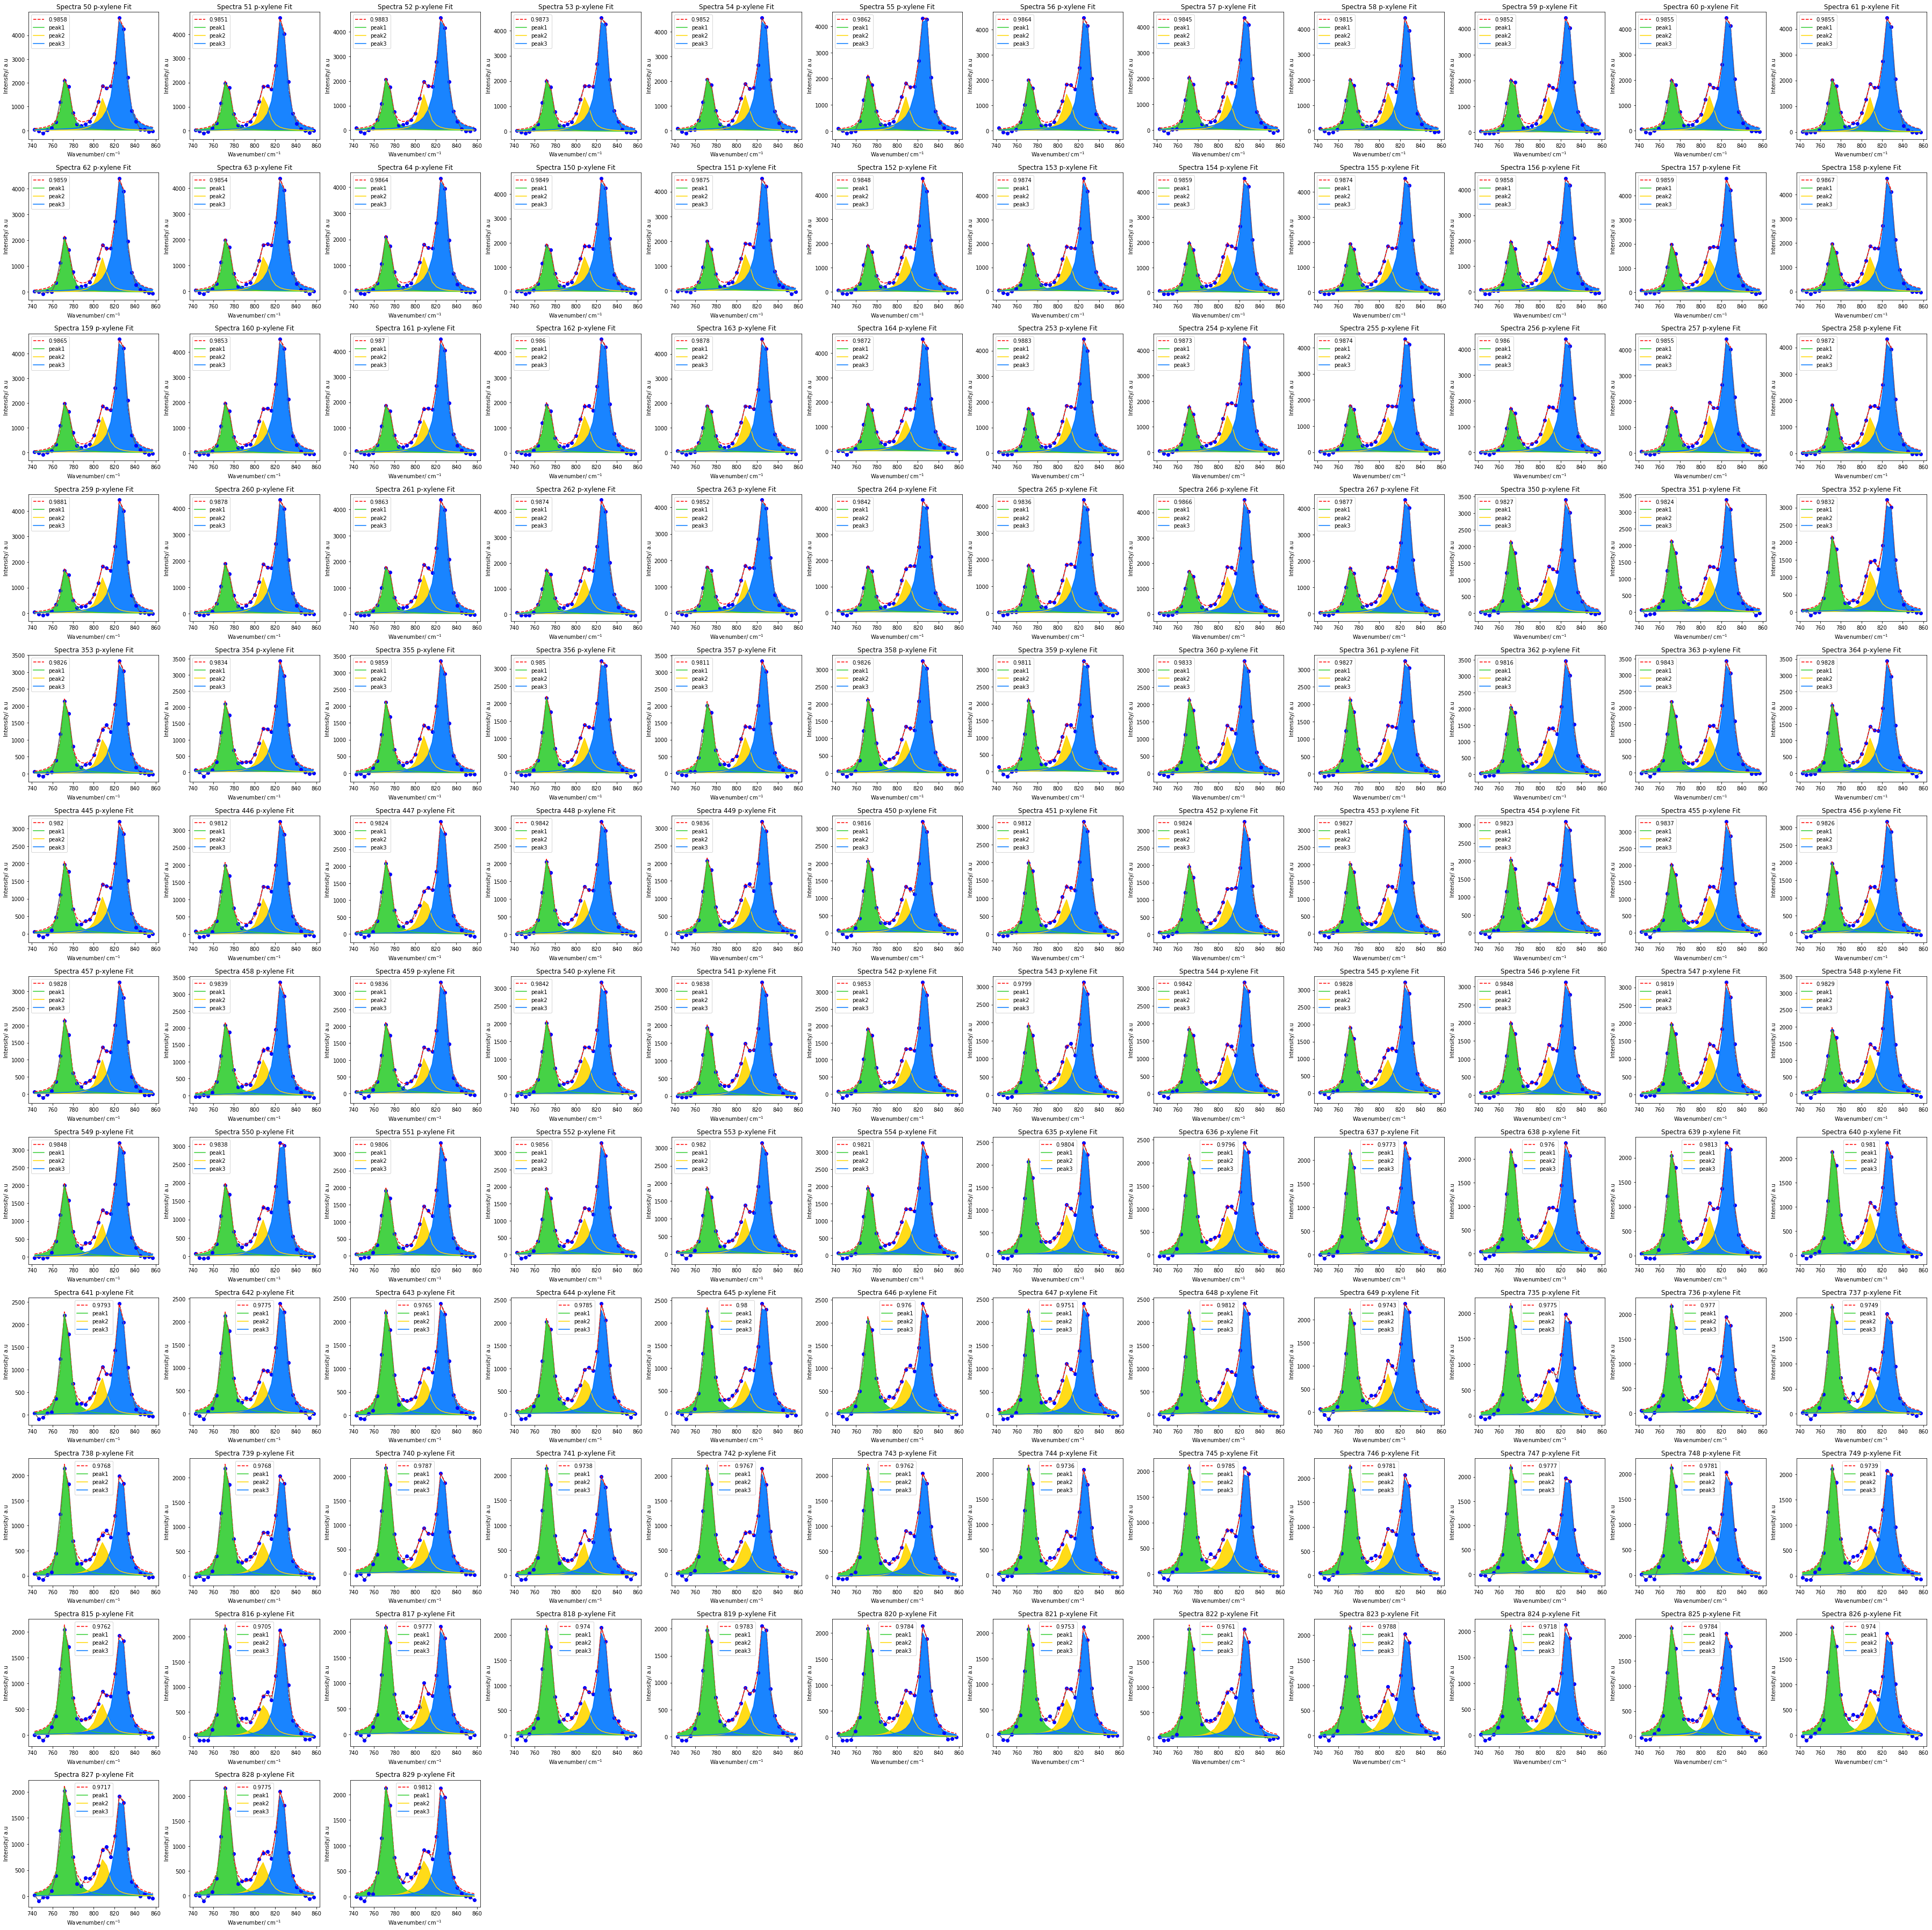

In [24]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])
Area_3 = collections.deque([])

pbar = tqdm(total = len(df_pxyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (50,50))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='ampL3', value = ampL3, min = 0)
pfit.add(name='cenL1', value = cenL1, min = 770, max = 780)
pfit.add(name='cenL2', value = cenL2, min = 805, max = 815)
pfit.add(name='cenL3', value = cenL3, min = 820, max = 830)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)
pfit.add(name='widL3', value = widL3, min = 0)
pfit.add(name='widL4', value = widL4, min = 0)

for i,item in df_pxyl.iterrows():
    
    x = df_pxyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:5].values.tolist():
        xbl.append(items)

    for items in y.index[25:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:5].tolist():
        ybl.append(items)

    for items in y.values[25:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['FWHM_L3'] = out.params.valuesdict()['widL3'] + out.params.valuesdict()['widL4']
    fit_params['Height_L1'] = 0.318309886*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.318309886*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    fit_params['Height_L3'] = 0.318309886*out.params.valuesdict()['ampL3']/max(2.220446049250313e-16, out.params.valuesdict()['widL3']+out.params.valuesdict()['widL4'])
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    peak3 = split_lorentzian(x,out.params.valuesdict()['ampL3'], out.params.valuesdict()['cenL3'], out.params.valuesdict()['widL3'], out.params.valuesdict()['widL4'])
    
    plt.subplot(np.ceil(np.sqrt(df_pxyl.shape[0])),np.ceil(np.sqrt(df_pxyl.shape[0])),(1+i))
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' p-xylene Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.plot(x, peak3,'#0077FF', label = 'peak3')
    plt.fill_between(x, peak3.min(), peak3, facecolor = '#0077FF', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    Area_3.append(integrate.simps(peak3, x))
    
    pbar.update(1)
    
plt.tight_layout()
plt.show()

In [25]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_pxyl'}, inplace=True)
results.describe()

ampL1         ampL2         ampL3       cenL1       cenL2  \
count    135.000000    135.000000    135.000000  135.000000  135.000000   
mean   30411.785962  18347.603043  58648.708515  772.827842  808.751105   
std     3000.831303   4178.969818  18099.775363    0.144889    0.400955   
min    23005.005893   9537.593726  32602.264618  772.461259  807.501851   
25%    28497.562389  14435.947918  40855.469838  772.736428  808.493031   
50%    30612.443891  18562.620707  57834.513886  772.828947  808.802575   
75%    32961.909858  21687.129382  79224.369247  772.922848  808.983280   
max    35414.502673  26023.145280  87610.188808  773.255056  809.729532   

            cenL3       widL1       widL2       widL3       widL4     R2_pxyl  \
count  135.000000  135.000000  135.000000  135.000000  135.000000  135.000000   
mean   826.872647    4.339012    5.657018    6.059576    4.448848    0.982036   
std      0.163950    0.279625    0.569840    0.397610    0.144174    0.004268   
min    826.493024    3.632867    4.627929    5.112164    4.050791    0.970546   
25%    826.742908    4.137244    5.289482    5.774950    4.348665    0.978503   
50%    826.881605    4.360783    5.531468    6.059858    4.436426    0.982748   
75%    826.983167    4.560631    5.934107    6.334646    4.545366    0.985476   
max    827.367555    4.980672    7.202343    7.172869    4.809473    0.988294   

          FWHM_L1     FWHM_L2     FWHM_L3    Height_L1    Height_L2  \
count  135.000000  135.000000  135.000000   135.000000   135.000000   
mean     8.678024   11.314035   10.508424  2228.733841  1049.422517   
std      0.559250    1.139679    0.432105   135.588028   284.229222   
min      7.265733    9.255858    9.162955  1844.436005   594.844547   
25%      8.274489   10.578964   10.241017  2145.807683   741.567950   
50%      8.721566   11.062936   10.507228  2257.410184  1050.027305   
75%      9.121261   11.868215   10.791821  2324.275990  1333.116945   
max      9.961345   14.404686   11.708577  2478.288610  1519.506279   

         Height_L3  
count   135.000000  
mean   1768.755043  
std     519.583302  
min    1031.984357  
25%    1248.623224  
50%    1743.378267  
75%    2352.371953  
max    2529.868527

In [26]:
df_area = pd.concat([df_area, pd.Series(Area_3), results['R2_pxyl']], axis=1)
df_area.rename(columns={0: 'pxyl Peak Area'}, inplace=True)
df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0                50         10    191170.418408  0.991583    81737.142956   
1                51         10    191385.219115  0.990241    74327.289595   
2                52         10    191217.485258  0.990860    78154.101852   
3                53         10    189232.629993  0.991241    76935.644477   
4                54         10    189532.481042  0.990826    77022.913131   
..              ...        ...              ...       ...             ...   
130             825         18    190354.633285  0.993168    35946.736451   
131             826         18    185233.016618  0.994808    31782.596467   
132             827         18    186562.508959  0.993476    30628.782650   
133             828         18    189691.137325  0.993985    33365.700477   
134             829         18    188551.450955  0.993679    31404.617104   

      R2_pxyl  
0    0.985799  
1    0.985054  
2    0.988294  
3    0.987297  
4    0.985218  
..        ...  
130  0.978448  
131  0.974037  
132  0.971685  
133  0.977506  
134  0.981235  

[135 rows x 6 columns]

In [27]:
# Keep only columns with R2 values above a threshold.
df_area = df_area[(df_area['R2_Vinyl'] > 0.96) & (df_area['R2_pxyl'] > 0.96)]

# Normalization
df_area['Vinyl Divide pxyl'] =  df_area['Vinyl Peak Area'] / df_area['pxyl Peak Area']

df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0                50         10    191170.418408  0.991583    81737.142956   
1                51         10    191385.219115  0.990241    74327.289595   
2                52         10    191217.485258  0.990860    78154.101852   
3                53         10    189232.629993  0.991241    76935.644477   
4                54         10    189532.481042  0.990826    77022.913131   
..              ...        ...              ...       ...             ...   
130             825         18    190354.633285  0.993168    35946.736451   
131             826         18    185233.016618  0.994808    31782.596467   
132             827         18    186562.508959  0.993476    30628.782650   
133             828         18    189691.137325  0.993985    33365.700477   
134             829         18    188551.450955  0.993679    31404.617104   

      R2_pxyl  Vinyl Divide pxyl  
0    0.985799           2.338844  
1    0.985054           2.574898  
2    0.988294           2.446672  
3    0.987297           2.459622  
4    0.985218           2.460729  
..        ...                ...  
130  0.978448           5.295464  
131  0.974037           5.828127  
132  0.971685           6.091085  
133  0.977506           5.685214  
134  0.981235           6.003940  

[135 rows x 7 columns]

In [28]:
# View the summary statistics
df_area_stats = df_area[['Condition', 'Vinyl Divide pxyl']].groupby('Condition').describe()
df_area_stats

Vinyl Divide pxyl                                                    \
                      count      mean       std       min       25%       50%   
Condition                                                                       
10                     15.0  2.502577  0.094708  2.338844  2.448663  2.495887   
11                     15.0  2.332383  0.048235  2.252892  2.296371  2.351653   
12                     15.0  2.209005  0.056146  2.078076  2.176923  2.193572   
13                     15.0  3.379324  0.067192  3.266890  3.337125  3.378466   
14                     15.0  3.449944  0.092713  3.315718  3.370405  3.449893   
15                     15.0  3.342917  0.126230  3.119925  3.271158  3.341066   
16                     15.0  4.999600  0.155505  4.722083  4.905158  4.979300   
17                     15.0  5.831321  0.219528  5.465410  5.726448  5.795643   
18                     15.0  5.724859  0.216675  5.295464  5.644658  5.733768   

                               
                75%       max  
Condition                      
10         2.554075  2.685440  
11         2.362187  2.401717  
12         2.245784  2.286773  
13         3.413045  3.524447  
14         3.525315  3.608526  
15         3.376830  3.611611  
16         5.063783  5.374890  
17         5.998814  6.245959  
18         5.833123  6.091085

In [29]:
mean = df_area_stats['Vinyl Divide pxyl', 'mean'].values
std = df_area_stats['Vinyl Divide pxyl', 'std'].values
condition = range(10,19)

In [30]:
df_ratio = pd.DataFrame({'Condition':condition, 'Mean Ratio':mean, 'Standard Deviation': std})
df_ratio

Condition  Mean Ratio  Standard Deviation
0         10    2.502577            0.094708
1         11    2.332383            0.048235
2         12    2.209005            0.056146
3         13    3.379324            0.067192
4         14    3.449944            0.092713
5         15    3.342917            0.126230
6         16    4.999600            0.155505
7         17    5.831321            0.219528
8         18    5.724859            0.216675

In [31]:
df_ratio.to_csv(r'C:\Users\Tan Jin Da\Desktop\High Throughput Experiments Data\201020 High Throughput Experiment Conditions 10 to 18\Online Raman\df_t90_ratio.csv')